In [39]:
import pandas as pd 
import numpy as np 
from pprint import pprint
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import psycopg2
import os


In [40]:
train = pd.read_csv('../inputs/train.csv')
test = pd.read_csv('../inputs/test.csv')
sample = pd.read_csv('../inputs/sample_submission.csv')
print(f'Training shape: {train.shape}, Testing Shape: {test.shape}, Sample Shape: {sample.shape}')



Training shape: (381109, 12), Testing Shape: (127037, 11), Sample Shape: (127037, 2)


In [41]:
# define the index id and join test with sample dataframe
test = test.set_index('id').join(sample.set_index('id'))
train = train.set_index('id')


In [43]:

# concatinate train and test dataframe for overall EDA 
df = pd.concat([train, test])
print(df.Response)

# create a dataframe for dtypes, % of null values, and count of null values 
df_details = pd.DataFrame(df.dtypes).T.rename(index={0:'datatype'})
df_details = df_details.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'num_null_values'}))
df_details = df_details.append(pd.DataFrame(df.isnull().sum()/len(df)*100).T.rename(index={0:'pct_null_values'}))
df_details
# no null values found

id
1         1
2         0
3         1
4         0
5         0
         ..
508142    0
508143    0
508144    0
508145    0
508146    0
Name: Response, Length: 508146, dtype: int64


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
datatype,object,int64,int64,float64,int64,object,object,float64,float64,int64,int64
num_null_values,0,0,0,0,0,0,0,0,0,0,0
pct_null_values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# cluster each datatype (int, float, object)
pprint(df.columns.to_series().groupby(df.dtypes).groups)


{dtype('int64'): Index(['Age', 'Driving_License', 'Previously_Insured', 'Vintage', 'Response'], dtype='object'),
 dtype('float64'): Index(['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel'], dtype='object'),
 dtype('O'): Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')}


In [6]:
# explore the shape (rows and columns) for dataframe
print(f'Number of rows of DataFrame: {df.shape[0]}')
print(f'Number of columns of DataFrame: {df.shape[1]}')

Number of rows of DataFrame: 508146
Number of columns of DataFrame: 11


In [7]:
df.head(10)
# clean the following columns [Gender, Vehicle_Age, Vehicle_Damage, ]

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0


In [8]:
# statisical summary for quantitative columns 
df.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,508146.000000,508146.000000,508146.000000,508146.000000,508146.000000,508146.000000,508146.000000,508146.000000
mean,38.808413,0.997936,26.406572,0.458667,30554.453041,111.975838,154.340123,0.091922
std,15.500179,0.045388,13.224921,0.498289,17146.574625,54.246027,83.668793,0.288917
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24381.000000,26.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31661.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39403.750000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [37]:
pct_response = (df.Response.value_counts()[1] /  df.Response.value_counts()[0]) *100
print(f'Percentage of Customers that are Interested {pct_response:0.2f}%')

Percentage of Customers that are Interested 10.12%


<AxesSubplot:title={'center':'Count of Interest or Not'}, xlabel='Response', ylabel='count'>

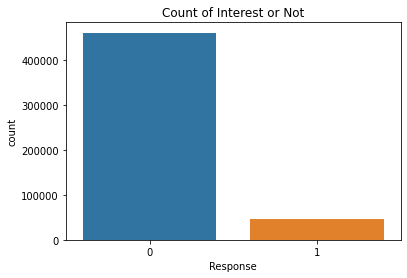

In [9]:
plt.title("Count of Interest or Not")
# 1 : Customer is interested, 0 : Customer is not interested
sns.countplot(x = "Response", data=df)

<AxesSubplot:title={'center':'Response based on Vehicle Damage'}, xlabel='Response', ylabel='count'>

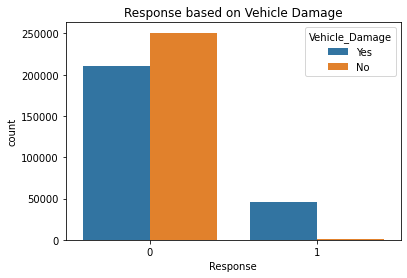

In [10]:

plt.title("Response based on Vehicle Damage")
sns.countplot(x = "Response", hue = 'Vehicle_Damage', data=df)
# Customer with their vehicle damaged in the past tend to be interested

<AxesSubplot:title={'center':'Response based on Previosly Insured'}, xlabel='Response', ylabel='count'>

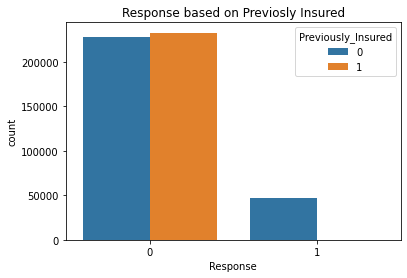

In [11]:
plt.title("Response based on Previosly Insured")
sns.countplot(x = "Response", hue = 'Previously_Insured', data=df)

<AxesSubplot:title={'center':'Response based on Vehicle Age'}, xlabel='Response', ylabel='count'>

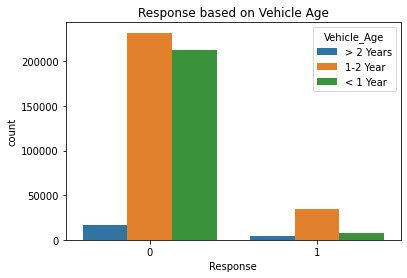

In [12]:
plt.title("Response based on Vehicle Age")
sns.countplot(x = "Response", hue = 'Vehicle_Age', data=df)

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:title={'center':'Response based on Gender Category'}, xlabel='Gender', ylabel='count'>

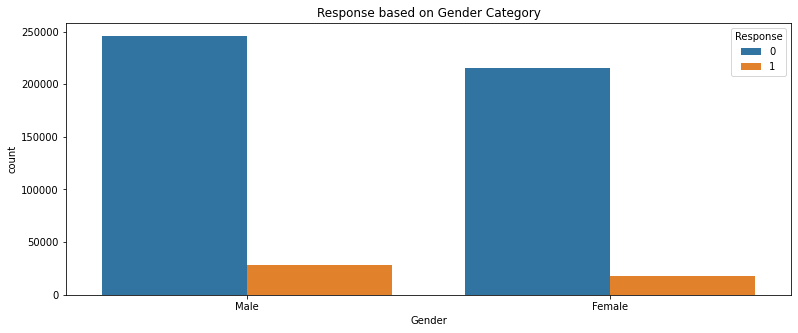

In [50]:
plt.figure(figsize = (13,5))
plt.title("Response based on Gender Category")
sns.countplot(df['Gender'], hue = df['Response'])

<AxesSubplot:>

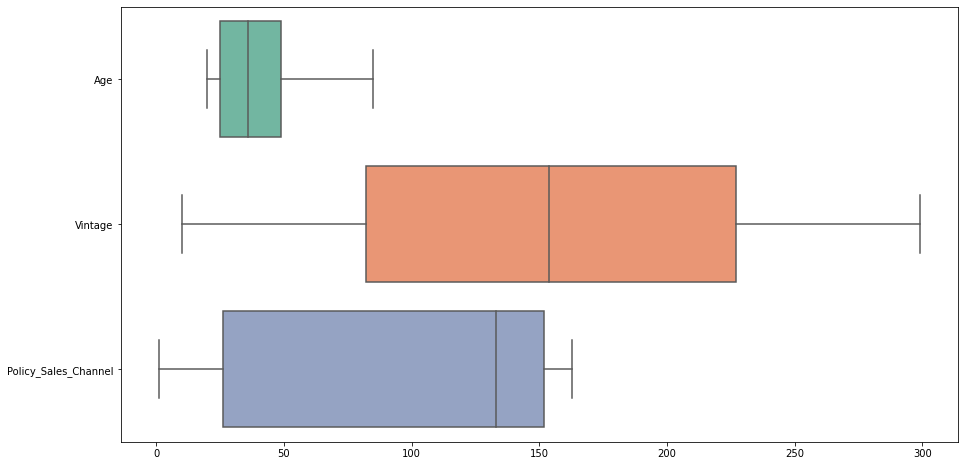

In [13]:
null_col = ['Age', 'Vintage','Policy_Sales_Channel']
plt.subplots(figsize=(15,8))
sns.boxplot(data=df[null_col], orient="h", palette="Set2")
# no outliers found 

<AxesSubplot:>

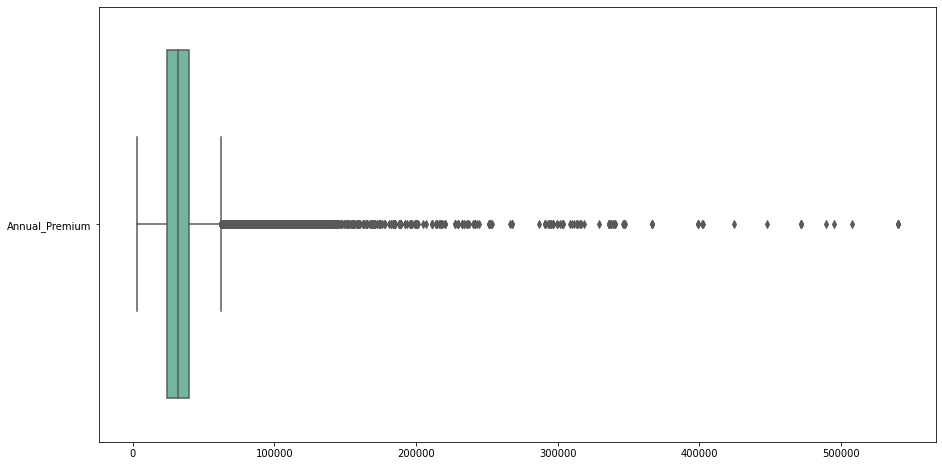

In [14]:
plt.subplots(figsize=(15,8))
sns.boxplot(data=df[['Annual_Premium']], orient="h", palette="Set2")

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

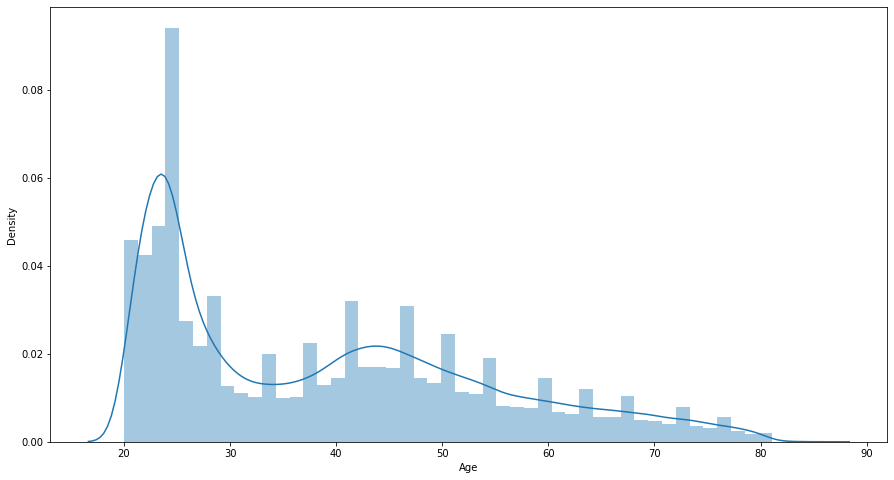

In [15]:
plt.subplots(figsize=(15,8))
sns.distplot(df.Age)


<AxesSubplot:>

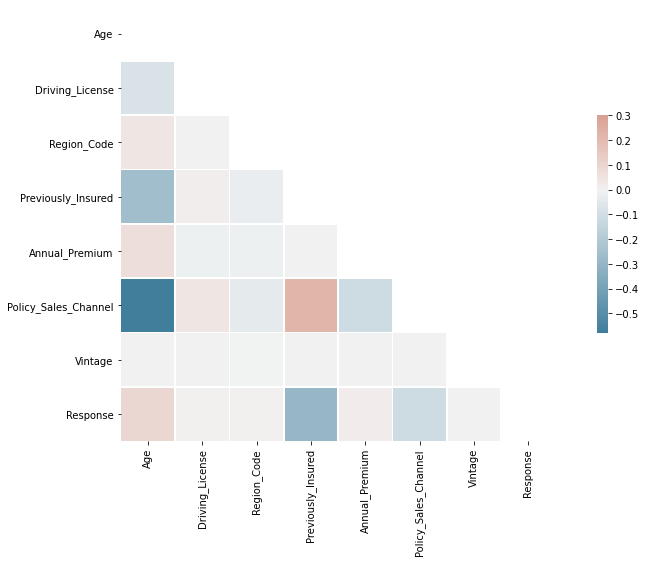

In [16]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(15,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# plt heatmap with mask and ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Policy Sales Channel has a high correlation with Age, relative to other features

In [17]:
#### CLEANING DATA 

In [18]:
cat_features = df[['Gender', 'Vehicle_Age', 'Vehicle_Damage']]

# printing unique values of each column
for col in cat_features.columns:
    print(f"{col}: {cat_features[col].unique()}\n")

Gender: ['Male' 'Female']

Vehicle_Age: ['> 2 Years' '1-2 Year' '< 1 Year']

Vehicle_Damage: ['Yes' 'No']



In [19]:
from sklearn.preprocessing import LabelEncoder

col = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
cat_df = df[col].apply(LabelEncoder().fit_transform)
cat_df

,Gender,Vehicle_Age,Vehicle_Damage
id,,,
1,1,2,1
2,1,0,0
3,1,2,1
4,1,1,0
5,0,1,0
...,...,...,...
508142,0,1,0
508143,0,0,1
508144,1,1,0


In [20]:
# define the index id and join test with sample dataframe
df = df.drop(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], axis=1)
df = pd.concat([df, cat_df], axis=1)
df.head()
print(df.dtypes)

Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
Gender                    int64
Vehicle_Age               int64
Vehicle_Damage            int64
dtype: object


In [21]:
replacements = {
    'int64': 'int',
    'float64': 'float'
}

In [24]:
col_str = ", ".join('{} {}'.format(n,d) for (n,d) in zip(df.columns, df.dtypes.replace(replacements)))

In [25]:
# database connection to aws 

conn_string = "host=healthinsurancedb2.c6jdwiadovx0.us-east-1.rds.amazonaws.com dbname='healthinsurancedb2' user='healthinsure2' password='healthinsurancedb2'"
 
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
print('opened database successfully')

OperationalError: could not connect to server: Operation timed out
	Is the server running on host "healthinsurancedb2.c6jdwiadovx0.us-east-1.rds.amazonaws.com" (54.162.161.251) and accepting
	TCP/IP connections on port 5432?
